In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py

from numpy.lib.recfunctions import append_fields

def fields_view(arr, columns):
    """ View several columns from a numpy record array 
    Stolen from http://stackoverflow.com/questions/15182381/how-to-return-a-view-of-several-columns-in-numpy-structured-array
    """
    # Single columns is easy:
    if isinstance(columns, str):
        return arr[columns]
    # Several 
    dtype2 = np.dtype({name:arr.dtype.fields[name] for name in columns})
    return np.ndarray(arr.shape, dtype2, arr, 0, arr.strides)

def filter_on_peaks(source, peaks_array):
    """Returns entries of source whose (Event, Peak) indices are present in peaks_array
    Find better name
    """
    return source[np.in1d(
        fields_view(source, ('Event', 'Peak')),
        fields_view(peaks_array, ('Event', 'Peak'))
    )]
    
def group_by(x, group_by_indices='Event', return_group_indices=False):
    """Splits x into LIST of arrays, each array with entries in cps that have same (Event, Peak) index
    Assumes cps is sorted by event and by peak (probably works in either order, reversed or not)
    If return_indices=True, returns list of arrays with indices of group elements in x instead.
    """
    # Support single index and list of indices
    try:
        group_by_indices[0]
    except TypeErrror:
        group_by_indices = tuple(group_by_indices)
    # Define array we'll split
    if return_group_indices:
        to_return = np.arange(len(x))
    else:
        to_return = x
    # Indices to determine split points from
    indices = fields_view(x, group_by_indices)
    # Should we split at all?
    if indices[0] == indices[-1]:
        return [to_return]
    else:
        # Split where indices changes value
        split_points = np.where((np.roll(indices, 1)!= indices))[0]
        # 0 shouldn't be a split_point, will be in it due to roll (and indices[0] != indices[-1]), so remove it
        split_points = split_points[1:]
        return np.split(to_return, split_points)
    
def maximum(x, key=lambda x:x, fallback=None):
    try:
        return max(x, key=key)
    except ValueError:
        return fallback
    

dt = 10 

In [47]:
import pandas as pd
hits = pd.read_hdf('../output.hdf5','Hit')

In [48]:
hits.head()

,Event,Hit,area,center,channel,found_in_pulse,height,index_of_maximum,is_rejected,left,noise_sigma,right
0,0,0,0.921984,440373.9375,64,0,0.642572,44037,0,44037,0.023100,44039
1,0,1,0.870217,2467593.5000,88,1,0.555721,246759,0,246758,0.025476,246761
2,0,2,1.156409,3133350.5000,82,2,0.689112,313335,0,313333,0.038358,313337
3,0,3,0.809180,6807022.5000,76,3,0.605451,680702,0,680702,0.024995,680703
4,0,4,1.077057,7015905.0000,86,4,0.669168,701590,0,701589,0.023151,701593


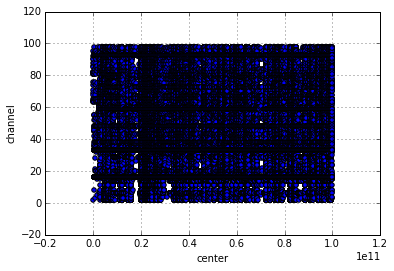

In [49]:
import matplotlib.pyplot as plt

hits.plot('center', 'channel', kind='scatter')

In [33]:
# Open the file
f = h5py.File('../output.hdf5')
for name in f:
    print(name)

Event
Hit
Pulse
pax_info


In [35]:
# Slurp all events and peaks in to memory
events = store['Event'][:]
#pulse = store['Pulse'][:]
hit = store['Hit'][:]

In [36]:
hit.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [12]:


# Group peaks by event
peaks_per_event = group_by(peaks, 'Event')

In [13]:
# Get the main s1 / s2 of an event
def get_main_peak(event_nr, peak_type):
    pks = peaks_per_event[event_nr]
    pks = pks[pks['type'] == peak_type]
    if len(pks):
        return max(pks, key=lambda x:x['area'])
    else:
        return None

In [14]:
# Make an s2 width / drift time scatter plot
s2_areas = []
s2_widths = []
drift_times = []
for e in np.arange(len(events)):
    main_s1 = get_main_peak(e, b's1')
    main_s2 = get_main_peak(e, b's2')
    if not (main_s1 and main_s2):
        # Event is missing one of the main peak types
        continue
    s2_widths.append(main_s2['median_absolute_deviation'])
    s2_areas.append(main_s2['area'])
    drift_times.append(dt * (main_s2['index_of_maximum'] - main_s1['index_of_maximum']))
drift_times = np.array(drift_times)
s2_widths = np.array(s2_widths)
s2_areas = np.array(s2_areas)

plt.figure(figsize=(10,7))
plt.scatter(drift_times/ units.us, s2_widths / units.us,
            marker='.', edgecolor=None, alpha=0.4, c=np.log10(s2_areas));
plt.ylim(0,2)
plt.xlabel('Drift time (us)')
plt.ylabel('S2 width (MAD, us)')
plt.colorbar(label='log10 S2 area (pe)')
plt.show()

IndexError: invalid index